In [128]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from matplotlib.gridspec import GridSpec 


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [129]:
dataframe = pd.read_csv(r'C:\Users\ADMIN\Downloads\dataset.csv')
dataframe=dataframe.drop('id', axis=1)
dataframe.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [130]:
def grab_columns(dataframe, categorial_th=10, car_th=20):


    categorial_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_categorial = [col for col in dataframe.columns if dataframe[col].nunique() < categorial_th and
                   dataframe[col].dtypes != "O"]
    categorial_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    categorial_cols = categorial_cols + num_but_categorial
    categorial_cols = [col for col in categorial_cols if col not in categorial_but_car]


    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_categorial]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'categorial_cols: {len(categorial_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'categorial_but_car: {len(categorial_but_car)}')
    print(f'num_but_categorial: {len(num_but_categorial)}')
    return categorial_cols, num_cols, categorial_but_car

In [131]:
def outlier_th(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    upper_bound = quartile3 + 1.5 * interquantile_range
    lower_bound = quartile1 - 1.5 * interquantile_range
    return lower_bound, upper_bound

def check_outlier(dataframe, col_name):
    lower_bound, upper_bound = outlier_th(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_bound) | (dataframe[col_name] < lower_bound)].any(axis=None):
        return True
    else:
        return False  

def replace_with_thresholds(dataframe, variable):
    lower_bound, upper_bound = outlier_th(dataframe, variable)
    dataframe.loc[(dataframe[variable] < lower_bound), variable] = lower_bound
    dataframe.loc[(dataframe[variable] > upper_bound), variable] = upper_bound

In [132]:
def missing (dataframe):
    missing_number = dataframe.isnull().sum().sort_values(ascending=False)
    missing_percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(dataframe)

,Missing_Number,Missing_Percent
bmi,201,0.039335
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
smoking_status,0,0.000000


In [133]:
 num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

In [134]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
dataframe['bmi'] = imp.fit_transform(dataframe['bmi'].to_numpy().reshape(-1, 1))
dataframe

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [135]:
categorial_cols, num_cols, categorial_but_car = grab_columns(dataframe)

Observations: 5110
Variables: 11
categorial_cols: 8
num_cols: 3
categorial_but_car: 0
num_but_categorial: 3


In [136]:
for col in num_cols:
    print(col, check_outlier(dataframe, col))

age False
avg_glucose_level False
bmi True


In [137]:
for col in num_cols:
    replace_with_thresholds(dataframe, col)
for col in num_cols:
    print(col, check_outlier(dataframe, col))

age False
avg_glucose_level False
bmi False


In [138]:
dataframe.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [139]:
dataframe.age[dataframe.age<=20] = 0
dataframe.age[(dataframe.age<=40) & (dataframe.age>20)] = 1
dataframe.age[(dataframe.age<=60) & (dataframe.age>40)] = 2
dataframe.age[dataframe.age>60] = 3

In [140]:
dataframe.smoking_status=[0 if item == "Unknown" else 1 if item=="never smoked" else 2 if item == "formerly smoked" else 3 for item in dataframe.smoking_status]

In [141]:
dataframe.Residence_type=[0 if item == "Urban" else 1 for item in dataframe.Residence_type]

In [142]:
dataframe.work_type=[0 if item == "Never_worked" else 1 if item=="children" else 2 if item == "Govt_job" else 3 if item == "Private" else 4 for item in dataframe.work_type]

In [143]:
dataframe.gender=[0 if item == "Male" else 1 for item in dataframe.gender]

In [144]:
dataframe.ever_married=[0 if item == "Yes" else 1 for item in dataframe.ever_married]

In [145]:
dataframe.bmi=[0 if item <=23.5 else 1 if item>23 and item<=28.1 else 2 if item >28.1 and item<=33.1 else 3 for item in dataframe.bmi]

In [146]:
dataframe.avg_glucose_level=[0 if item <=77.07 else 1 if item>77.07 and item<=91.68 else 2 if item >91.68 and item<=113.57 else 3 for item in dataframe.avg_glucose_level]

In [147]:
stroke = dataframe[dataframe.stroke==1]
not_stroke = dataframe[dataframe.stroke==0].sample(n = 1000,random_state=42)

In [148]:
stroke = dataframe[dataframe.stroke==1]

In [149]:
model_data=pd.concat([stroke,not_stroke])
y=model_data.stroke
x=model_data.drop("stroke",axis=1)

In [150]:
x.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,3.0,0,1,0,3,0,3,3,2
1,1,3.0,0,0,0,4,1,3,1,1
2,0,3.0,0,1,0,3,1,2,2,1
3,1,2.0,0,0,0,3,0,3,3,3
4,1,3.0,1,0,0,4,1,3,1,1


In [151]:
sc=StandardScaler()
dataframe[num_cols] = sc.fit_transform(dataframe[num_cols])

In [152]:
dataframe.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1.292093,0,1,0,3,0,1.332346,1.393440,2,1
1,1,1.292093,0,0,0,4,1,1.332346,-0.428586,1,1
2,0,1.292093,0,1,0,3,1,0.438870,0.482427,1,1
3,1,0.358864,0,0,0,3,0,1.332346,1.393440,3,1
4,1,1.292093,1,0,0,4,1,1.332346,-0.428586,1,1


In [153]:
X_train,X_test, y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [154]:
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [155]:
from sklearn.model_selection import train_test_split, cross_validate
log_model = LogisticRegression().fit(X_train, y_train)

cv_results = cross_validate(log_model,
                            X_train, y_train,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [156]:
print("test_accuracy: ", cv_results['test_accuracy'].mean())
print("test_f1: ", cv_results['test_f1'].mean())
print("test_roc_auc: ", cv_results['test_roc_auc'].mean())
print("prec: ", cv_results['test_precision'].mean())
print("recall: ", cv_results['test_recall'].mean())

test_accuracy:  0.805838383838384
test_f1:  0.3084553641085081
test_roc_auc:  0.817235014619883
prec:  0.5319444444444443
recall:  0.22736842105263158


In [157]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, roc_auc_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier()

gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1)
print('Recall:', recall)
print('Precision:', precision)
print('ac',accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))



Accuracy: 0.825
F1 score: 0.42622950819672134
Recall: 0.3611111111111111
Precision: 0.52
ac 0.825
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       164
           1       0.52      0.36      0.43        36

    accuracy                           0.82       200
   macro avg       0.69      0.64      0.66       200
weighted avg       0.81      0.82      0.81       200

Confusion Matrix:
 [[152  12]
 [ 23  13]]
AUC Score: 0.643970189701897
MSE: 0.175
G-mean: 0.5785225552072009
Kappa: 0.32692307692307687
MCC: 0.33449275712387466
Accuracy: 0.825
F1 score: <function f1_score at 0x000001A53A779300>
Recall: 0.3611111111111111
Precision: 0.52
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       164
           1       0.52      0.36      0.43        36

    accuracy                           0.82       200
   macro avg       0.69      0.64      0.66       200
weighte

Accuracy: 0.76875
F1 score: 0.39344262295081966
Recall: 0.2926829268292683
Precision: 0.6
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       119
           1       0.60      0.29      0.39        41

    accuracy                           0.77       160
   macro avg       0.70      0.61      0.63       160
weighted avg       0.74      0.77      0.74       160

ROC AUC: 0.6127280180364829


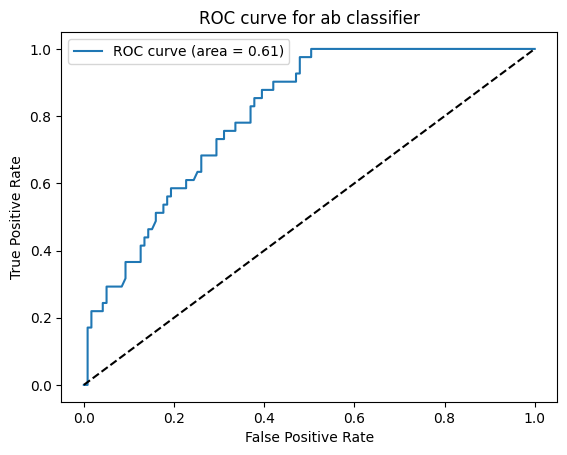

In [158]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=42)


clf = AdaBoostClassifier()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)


from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report

#roc_curve_display = RocCurveDisplay.from_estimator(log_model,X_test,y_test)

#plt.title('ROC curve')
#plt.plot([0, 1], [0, 1], 'k--')
#plt.show()
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for ab classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Accuracy: 0.7890625
F1 score: 0.27027027027027023
Recall: 0.16129032258064516
Precision: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.79      0.99      0.88        97
           1       0.83      0.16      0.27        31

    accuracy                           0.79       128
   macro avg       0.81      0.58      0.57       128
weighted avg       0.80      0.79      0.73       128

ROC AUC: 0.5754905221150649


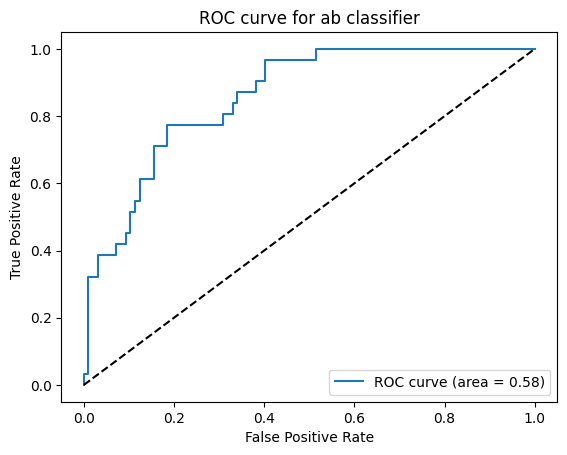

In [159]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=42)


clf = AdaBoostClassifier()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)


from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report

#roc_curve_display = RocCurveDisplay.from_estimator(log_model,X_test,y_test)

#plt.title('ROC curve')
#plt.plot([0, 1], [0, 1], 'k--')
#plt.show()
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for ab classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Accuracy: 0.7572815533980582
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        88
           1       0.31      0.53      0.39        15

    accuracy                           0.76       103
   macro avg       0.61      0.66      0.62       103
weighted avg       0.82      0.76      0.78       103

ROC AUC: 0.6643939393939393
p: 0.3076923076923077
R: 0.5333333333333333
f1 0.3902439024390244


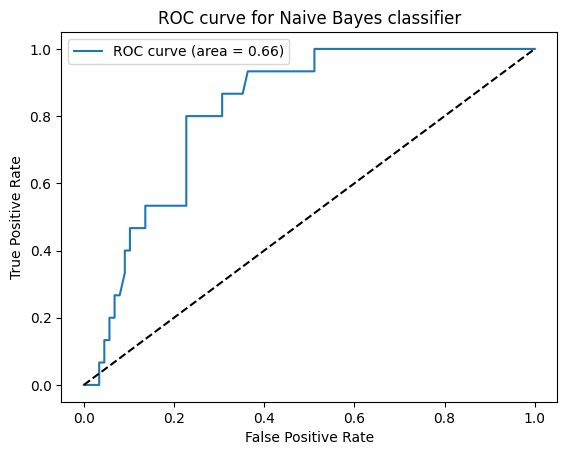

MSE: 0.24271844660194175
Kappa: 0.25210572175428414
MCC: 0.2669750812397418
G-mean: 0.2297506711883346


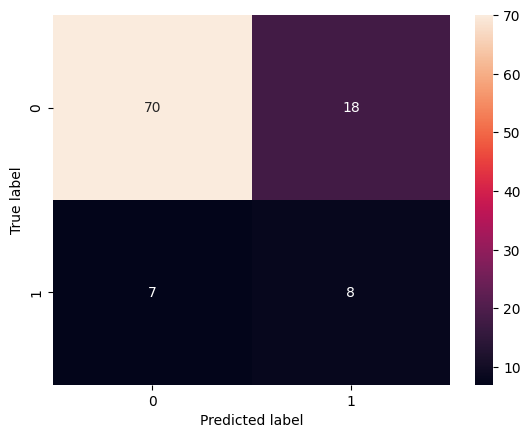

In [160]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=42)  
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)
y_pred = naive_bayes_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)
print('p:', precision)
print('R:', recall)
print('f1', f1)
from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Naive Bayes classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()
confusion_matrix = confusion_matrix(y_test, y_pred)
acc = round(accuracy_score(y_test, y_pred), 3)
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")


plt.xlabel('Predicted label')
plt.ylabel('True label')

from sklearn.metrics import mean_squared_error, cohen_kappa_score, matthews_corrcoef, f1_score

def mse(y_true, y_pred):
 
  return mean_squared_error(y_true, y_pred)

def kappa(y_true, y_pred):

  return cohen_kappa_score(y_true, y_pred)

def mcc(y_true, y_pred):
  

  return matthews_corrcoef(y_true, y_pred)

def g_mean(y_true, y_pred):

  tpr = np.mean(y_pred * y_true)
  tnr = np.mean((1 - y_pred) * (1 - y_true))
  return np.sqrt(tpr * tnr)

mse = mse(y_test, y_pred)
kappa = kappa(y_test, y_pred)
mcc = mcc(y_test, y_pred)
g_mean = g_mean(y_test, y_pred)

print("MSE:", mse)
print("Kappa:", kappa)
print("MCC:", mcc)
print("G-mean:", g_mean)

Accuracy: 0.7619047619047619
ROC AUC: 0.47058823529411764
p: 0.0
R: 0.0
f1 0.0
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        17
           1       0.00      0.00      0.00         4

    accuracy                           0.76        21
   macro avg       0.40      0.47      0.43        21
weighted avg       0.65      0.76      0.70        21

Kappa: -0.08247422680412386
MCC: -0.10846522890932808
MSE: 0.23809523809523808
G mean: 0.0
ROC AUC: 0.47058823529411764


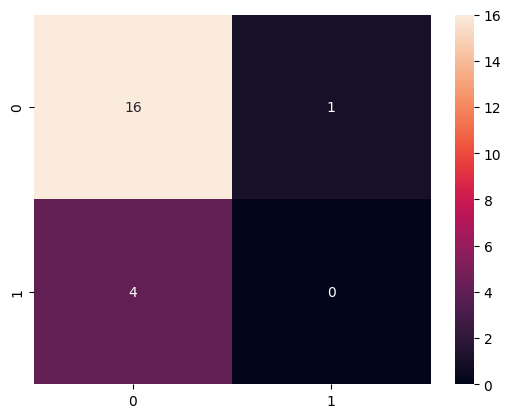

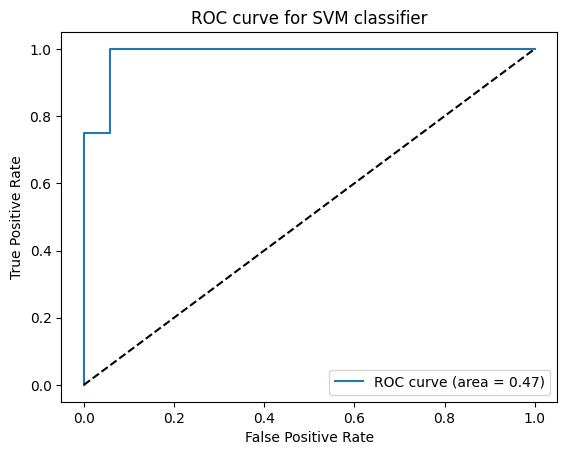

In [167]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score,cohen_kappa_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

svm = SVC(kernel='rbf', C=9.0, gamma=0.9)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('ROC AUC:', roc_auc)
print('p:', precision)
print('R:', recall)
print('f1', f1)
print(classification_report(y_test, y_pred))
print('Kappa:', kappa)
print('MCC:', mcc)
print('MSE:', mse)
print('G mean:', g_mean)
print('ROC AUC:', roc_auc)
confusion_matrix = confusion_matrix(y_test, y_pred)
acc = round(accuracy_score(y_test, y_pred), 3)
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")
sensitivity = confusion_matrix[1, 1] / (confusion_matrix[1, 0] + confusion_matrix[1, 1])
specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])

g_mean = (sensitivity * specificity)**0.5

plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Learning rate set to 0.005796
0:	learn: 0.6879390	total: 2.92ms	remaining: 2.92s
1:	learn: 0.6831920	total: 6.75ms	remaining: 3.37s
2:	learn: 0.6790078	total: 10.8ms	remaining: 3.58s
3:	learn: 0.6752639	total: 12.8ms	remaining: 3.17s
4:	learn: 0.6709496	total: 18.2ms	remaining: 3.63s
5:	learn: 0.6656644	total: 23.7ms	remaining: 3.93s
6:	learn: 0.6616560	total: 26.6ms	remaining: 3.77s
7:	learn: 0.6591991	total: 28.9ms	remaining: 3.58s
8:	learn: 0.6550936	total: 32.9ms	remaining: 3.62s
9:	learn: 0.6502461	total: 36.6ms	remaining: 3.62s
10:	learn: 0.6467789	total: 40.5ms	remaining: 3.64s
11:	learn: 0.6428905	total: 42.5ms	remaining: 3.5s
12:	learn: 0.6389878	total: 46ms	remaining: 3.49s
13:	learn: 0.6345257	total: 49.2ms	remaining: 3.46s
14:	learn: 0.6293778	total: 51.8ms	remaining: 3.4s
15:	learn: 0.6254369	total: 54.5ms	remaining: 3.35s
16:	learn: 0.6224350	total: 57ms	remaining: 3.29s
17:	learn: 0.6184213	total: 62.5ms	remaining: 3.41s
18:	learn: 0.6154031	total: 66.1ms	remaining: 3.41

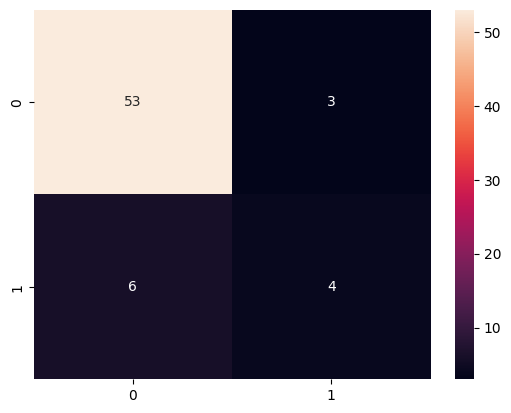

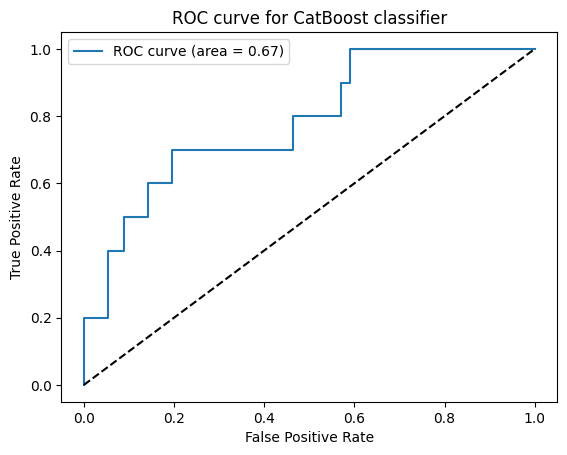

In [162]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score,cohen_kappa_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

model = CatBoostClassifier ()
model.fit (X_train, y_train)
y_pred = model.predict (X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt=".0f")
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Acuuracy:",accuracy)
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for CatBoost classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Acuuracy: 0.712
Accuracy: 0.712
F1 score: 0.2105263157894737
Recall: 0.2
Precision: 0.2222222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82        42
           1       0.22      0.20      0.21        10

    accuracy                           0.71        52
   macro avg       0.52      0.52      0.52        52
weighted avg       0.70      0.71      0.71        52

AUC Score: 0.5166666666666667
MSE: 0.28846153846153844
G-mean: 0.408248290463863
Kappa: 0.034653465346534795
MCC: 0.03472545204616505


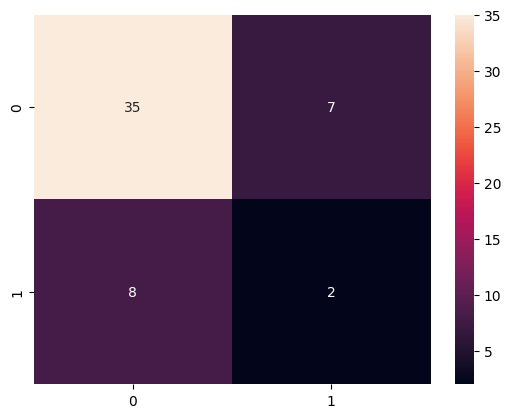

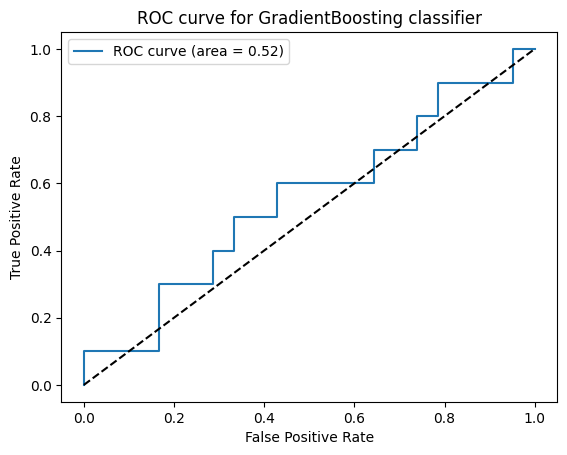

In [163]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, roc_auc_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.2, random_state=42)

model = GradientBoostingClassifier ()
model.fit (X_train, y_train)
y_pred = model.predict (X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Acuuracy:",accuracy)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1)
print('Recall:', recall)
print('Precision:', precision)
sns.heatmap(conf_matrix, annot=True, fmt=".0f")
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for GradientBoosting classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Acuuracy: 0.786
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88        33
           1       0.50      0.11      0.18         9

    accuracy                           0.79        42
   macro avg       0.65      0.54      0.53        42
weighted avg       0.74      0.79      0.73        42

AUC Score: 0.5404040404040404
MSE: 0.21428571428571427
G-mean: 0.3282439759448873
Kappa: 0.11267605633802813
MCC: 0.1556997888323046


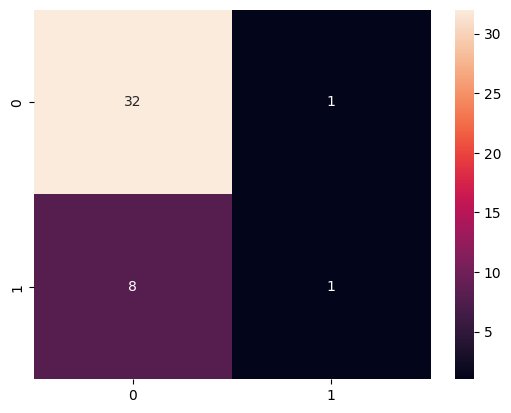

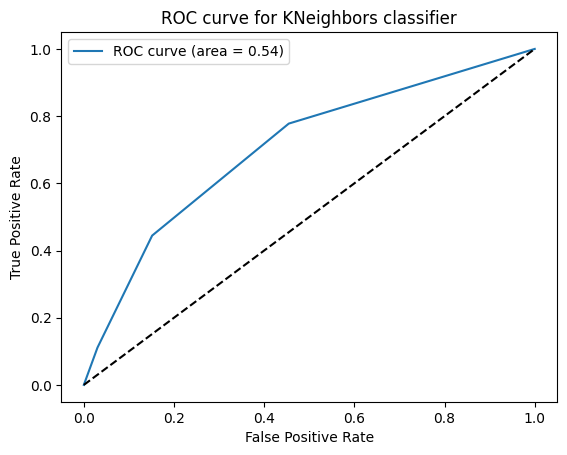

In [164]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, roc_auc_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

model = KNeighborsClassifier ()
model.fit (X_train, y_train)
y_pred = model.predict (X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Acuuracy:",accuracy)

sns.heatmap(conf_matrix, annot=True, fmt=".0f")
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for KNeighbors classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [165]:
import tensorflow as tf
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
ann=tf.keras.Sequential()

ann.add(tf.keras.layers.Dense(units=25,activation='relu'))

ann.add(tf.keras.layers.Dense(units=25,activation='relu'))

ann.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

ann.compile('adam','binary_crossentropy',metrics=['accuracy'])

In [416]:
result=ann.fit(X_train,y_train,epochs=15)

Epoch 1/15
5/5 [==============================] - 3s 6ms/step - loss: 0.9726 - accuracy: 0.1591
Epoch 2/15
5/5 [==============================] - 0s 6ms/step - loss: 0.8743 - accuracy: 0.1970
Epoch 3/15
5/5 [==============================] - 0s 6ms/step - loss: 0.7890 - accuracy: 0.2652
Epoch 4/15
5/5 [==============================] - 0s 6ms/step - loss: 0.7226 - accuracy: 0.4470
Epoch 5/15
5/5 [==============================] - 0s 6ms/step - loss: 0.6638 - accuracy: 0.6439
Epoch 6/15
5/5 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.7576
Epoch 7/15
5/5 [==============================] - 0s 6ms/step - loss: 0.5704 - accuracy: 0.7955
Epoch 8/15
5/5 [==============================] - 0s 8ms/step - loss: 0.5350 - accuracy: 0.8258
Epoch 9/15
5/5 [==============================] - 0s 6ms/step - loss: 0.5048 - accuracy: 0.8485
Epoch 10/15
5/5 [==============================] - 0s 8ms/step - loss: 0.4774 - accuracy: 0.8561
Epoch 11/15
5/5 [======================

In [417]:
from sklearn.metrics import confusion_matrix
y_pred=[]
for i in ann.predict(X_test):
    if i>0.5:
        y_pred.append(1)
    if i<0.5:
        y_pred.append(0)
confusion_matrix(y_test,y_pred)

2/2 [==============================] - 0s 8ms/step


array([[22,  0],
       [12,  0]], dtype=int64)

In [418]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
accuracy


0.6470588235294118

Acuuracy: 0.647
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88        33
           1       0.50      0.11      0.18         9

    accuracy                           0.79        42
   macro avg       0.65      0.54      0.53        42
weighted avg       0.74      0.79      0.73        42

AUC Score: 0.5
MSE: 0.35294117647058826
G-mean: 0.0
Kappa: 0.0


AttributeError: 'Sequential' object has no attribute 'predict_proba'

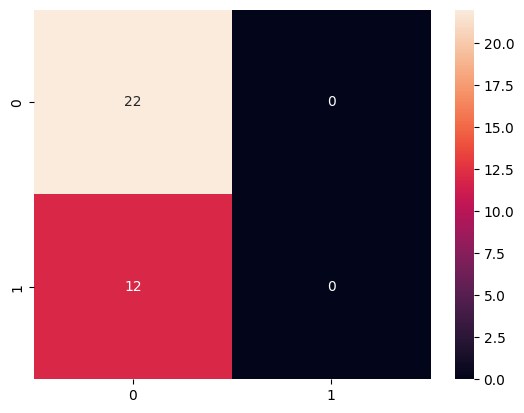

<Figure size 640x480 with 0 Axes>

In [419]:
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Acuuracy:",accuracy)

sns.heatmap(conf_matrix, annot=True, fmt=".0f")
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, ann.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for NeuralNetwork classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [86]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, roc_curve, roc_auc_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=42)

clf = XGBClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Acuuracy:",accuracy)


print('Accuracy:', accuracy)
print('F1 score:', f1)
print('Recall:', recall)
print('Precision:', precision)
sns.heatmap(conf_matrix, annot=True, fmt=".0f")
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBclassifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Acuuracy: 0.762
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.86        17
           1       0.00      0.00      0.00         4

    accuracy                           0.76        21
   macro avg       0.40      0.47      0.43        21
weighted avg       0.65      0.76      0.70        21

AUC Score: 0.47058823529411764
MSE: 0.23809523809523808
G-mean: 0.0
Kappa: -0.08247422680412386
MCC: -0.10846522890932808


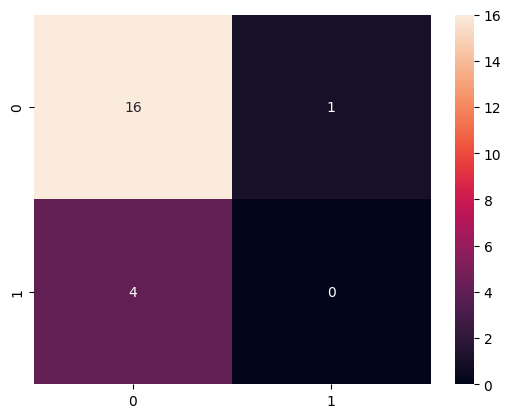

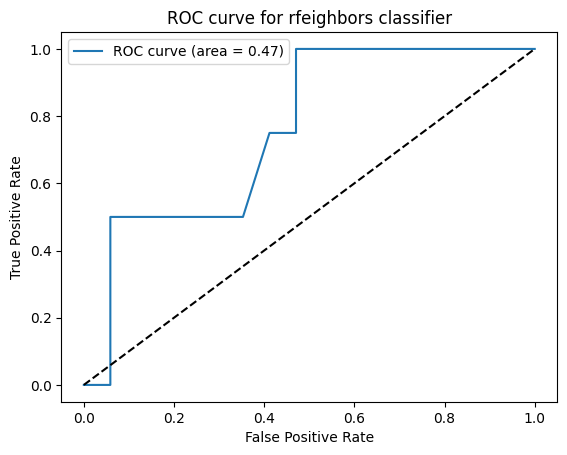

In [421]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, roc_auc_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
                                                   

model = RandomForestClassifier()
model.fit (X_train, y_train)
y_pred = model.predict (X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Acuuracy:",accuracy)

sns.heatmap(conf_matrix, annot=True, fmt=".0f")
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for rf classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate
log_model =RandomForestClassifier().fit(X_train, y_train)

cv_results = cross_validate(log_model,
                            X_train, y_train,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [ ]:
print("test_accuracy: ", cv_results['test_accuracy'].mean())
print("test_f1: ", cv_results['test_f1'].mean())
print("test_roc_auc: ", cv_results['test_roc_auc'].mean())
print("prec: ", cv_results['test_precision'].mean())
print("recall: ", cv_results['test_recall'].mean())

In [422]:
model = RandomForestClassifier ()
model.fit (X_train, y_train)

RandomForestClassifier()

In [424]:
from sklearn.metrics import classification_report, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
y_pred = model.predict (X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = accuracy_score(y_test, y_pred)
print('accuracy',accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
print("Confusion Matrix:\n", conf_matrix)

accuracy 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         2

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Confusion Matrix:
 [[12  0]
 [ 0  2]]
AUC Score: 1.0
MSE: 0.0
G-mean: 1.0
Kappa: 1.0
MCC: 1.0
Confusion Matrix:
 [[12  0]
 [ 0  2]]
